# Approximating derivatives of noisy functions

Assume we have a ground-truth function $f(x)$ which we approximate via some noisy procedure (eg. a machine learning model) through $\hat f(x)$, such that

$$\hat f(x) = f(x) + \epsilon(x)$$

where we let the noise $\epsilon$ depend on $x$. 

We know that finite differences approximate the derivative at a given point, and we want to know how well our noisy estimates can be used to approximate the derivatives.

We have, for any finite step $h > 0$, 

$$\frac{\hat f(x+h) - \hat f(x)}{h} = \frac{ f(x+h) - f(x)}{h} + \frac{\epsilon(x+h) - \epsilon(x)}{h}$$

Taylor's theorem with Lagrange remainder gives

$$f(x+h) = f(x) + h f'(x) + \frac{h^2}{2} f''(\xi),\qquad \mbox{for some }\xi \in [x, x+h],$$

which, substituted above, yields

$$\frac{\hat f(x+h) - \hat f(x)}{h} = f'(x) + \frac{h}{2}f''(\xi) + \frac{\epsilon(x+h) - \epsilon(x)}{h}$$

The mean square difference between the left-hand side and $f'(x)$ is then

\begin{align*}
\mathbb E\left[\left(\frac{\hat f(x+h) - \hat f(x)}{h} - f'(x) \right)^2\right] &= \mathbb E\left[\left(\frac{h}{2}f''(\xi) + \frac{\epsilon(x+h) - \epsilon(x)}{h}\right)^2\right]\\
&= \mathbb E\left[ \frac{h^2}{4}(f''(\xi))^2  + f''(\xi) (\epsilon(x+h) - \epsilon(x)) + \left(\frac{\epsilon(x+h) - \epsilon(x)}{h}\right)^2 \right]
\end{align*}

Let $N_h = \epsilon(x+h) - \epsilon(x)$ - we explicity make it a function of $h$ only if we assume homoscedasticity. We may assume each $\epsilon$ term has zero mean, so

$$\mathbb E[N_h] = 0.$$

The second moment is

$$\mathbb E[N_h^2] = \mathbb E[(\epsilon(x+h) - \epsilon(x))^2]= 2 \sigma^2 - 2 \mathbb E[\epsilon(x+h) \epsilon(x)]$$

where $\sigma^2 \equiv \mathrm{Var}\, \epsilon(x) = \mathrm{Var}\, \epsilon(x+h)$, assumed equal for all $x$.

Calling the **normalized 2-point function**

$$\boxed{\phi(h) = \frac{\mathbb E[\epsilon(x+h) \epsilon(x)]}{\sigma^2}}$$

we have

$$\varepsilon^2 \equiv \mathbb E\left[\left(\frac{\hat f(x+h) - \hat f(x)}{h} - f'(x) \right)^2\right] = \frac{h^2}{4}(f''(\xi))^2 + \frac{2\sigma^2}{h^2}(1 - \phi(h))\qquad (*)$$

### Case 1: uncorrelated noise $\phi = 0$

In this case, we get a mean squared error of

$$\boxed{\varepsilon^2 = C h^2 + \frac{D}{h^2}}$$

where $C \equiv f''(\xi)^2/4$ and $D = 2 \sigma^2$.

It is interesting to see the two sources of error: the first comes from the numerical approximation, and goes to zero as we reduce the step-size $h$; the other one comes from the noise, and actually diverges if the step is too small, but gets "washed away" once the step size grows.

In particular, the total error has a minimum:

$$\left.\frac{d \varepsilon^2}{dh}\right|_{h=h_*} = 0 \; \Rightarrow \; h_* = \left(\frac DC \right)^{1/4}$$

which gives a minimum error $\varepsilon^2_\mathrm{min} = \sqrt{4 C D}$, or

$$\boxed{\varepsilon^2_\mathrm{min} =\sqrt 2 \sigma |f''(\xi)| }\quad \mbox{(uncorrelated case)}$$

**Plotting the error**

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

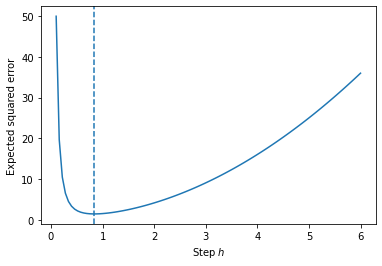

In [76]:
h = np.linspace(0.1, 6, 100)

C = 1
D = 0.5

plt.plot(h, C*h**2 + D/h**2)
plt.axvline((D/C)**0.25, linestyle='--')
plt.xlabel('Step $h$')
plt.ylabel('Expected squared error')
plt.show()

Hence, the error depends linearly on the noise standard deviation, as well as on (the magnitude of) the curvature of the function close to the point we are interested in calculating the derivative.

**Making a numerical approximator**

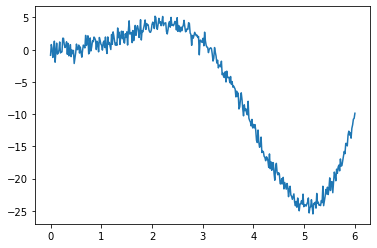

In [102]:
x = np.linspace(0, 6, num=400)
np.random.seed(123)
y = x**2 * np.sin(x) + 0.8*np.random.randn(*x.shape) # N(0,1) noise

dy = 2*x*np.sin(x) + x**2 * np.cos(x) # real derivative

df = pd.DataFrame({'x': x,
                   'y': y,
                   'dy': dy})
plt.plot(x, y)
plt.show()

In [103]:
h_list, error_list = [], []
for i in range(5,100):
    h = x[i] - x[0]
    h_list.append(h)
    
    df['dy_num'] = (df['y'] - df['y'].shift(i))/h

    df_nonnan = df.dropna()
    error = ((df_nonnan['dy'] - df_nonnan['dy_num'])**2).mean()
    error_list.append(error)
    
h_list = np.array(h_list)
error_list = np.array(error_list)

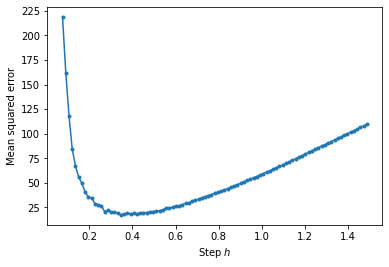

In [104]:
plt.plot(h_list, error_list, marker='.')
plt.xlabel("Step $h$")
plt.ylabel('Mean squared error')
plt.show()

This is qualitatively the same result!

Let us plot the numerical derivative with minimum error:

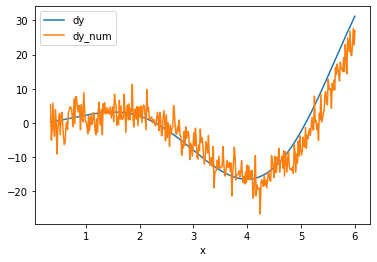

In [105]:
h_best = h_list[np.argmin(error_list)]
dx = x[1] - x[0]

i = int(h_best/dx)

h = h_best
df['dy_num'] = (df['y'] - df['y'].shift(i))/h_best
df_nonnan = df.dropna()

df_nonnan.set_index('x')[['dy', 'dy_num']].plot()
plt.show()

https://web.media.mit.edu/~crtaylor/calculator.html